Note: with the direct mean calculation, the total contribution to the mean of all points will sum to 0 - meaning it is impossible to distribute the shap values among them and total anything other than 0

Solution 1: avoid negative contributions

Solution 2 (currently used): scale around mean, not 0 - so a point equal to the mean contributes "mean" times

In [1]:
# IMPORTS

import sys
import os
import pandas as pd
import pickle
import featuretools as ft
import matplotlib.pyplot as plt
import numpy as np
import shap

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from model.data import get_patient_records, load_pic

In [2]:
# DIRS FOR LOADING AND SAVING

ROOT = os.path.abspath('../')
PIC_dir = os.path.join(ROOT, 'data/raw/PIC_mini/')
input_dir = os.path.join(ROOT, 'data/inputs')
output_dir = os.path.join(ROOT, 'data/intermediate/')

In [3]:
# FUNCTIONS FOR SAVING A LOADING ENTITY SET

def save_entityset(entityset):  # saves a serialized entity set in output_dir/entityset
    with open(os.path.join(output_dir, 'entityset'), 'wb') as f:
        pickle.dump(entityset, f)
        
def load_entityset(): # loads a serialized entiy set
    with open(os.path.join(output_dir, 'entityset'), 'rb') as f:
        return pickle.load(f)
    
def save_fm(df, fm_list, token=''):  # saves a fm_list both as a pickle and a csv
    if str(token) != '':
        token = '_' + str(token)
    with open(os.path.join(output_dir, 'fl{}.pkl'.format(token)), 'wb') as f:
        pickle.dump(fm_list, f)
    df.to_csv(os.path.join(output_dir, 'fm{}.csv'.format(token)))
    
def load_fm(token=None): # loads an fm_list both as an object and a DataFrame
    if str(token) != '':
        token = '_' + str(token)
    with open(os.path.join(output_dir, 'fl{}.pkl'.format(token)), 'rb') as f:
        fm_list = pickle.load(f)
    df = pd.read_csv(os.path.join(output_dir, 'fm{}.csv'.format(token)), index_col=0)
    return df, fm_list

In [4]:
# LOAD THE ENTITY SET

es = load_pic()

Prune (0/1934) rows.
Prune (0/1996) rows.
Prune (0/2108) rows.
Prune (0/1838) rows.
Prune (0/3778) rows.
Prune (0/754213) rows.
Prune (0/75981) rows.
Prune (0/1724805) rows.
Prune (0/29547) rows.
Prune (0/39872) rows.
Prune (0/450989) rows.
Prune (253/2837) rows.
Prune (0/7849) rows.
Prune (0/171332) rows.
Prune (0/479) rows.
Prune (0/832) rows.
Prune (0/25379) rows.


In [5]:
# REQUIRED INPUTS

df, fm_list = load_fm('signal_only')

model = pickle.load(open(os.path.join(input_dir, "model.pkl"), "rb"))
X_train = pd.read_csv(os.path.join(input_dir, "train.csv"), index_col=0)
X_test = pd.read_csv(os.path.join(input_dir, "test.csv"), index_col=0)
transformers = pickle.load(open(os.path.join(input_dir, "transformers.pkl"), "rb"))

explainer = shap.TreeExplainer(model)

In [15]:
# HELPER FUNCTIONS FOR EXPLANATION

def get_record_id_from_name(record_name, feature_table_name):
    # Get the corresponding record code from an English feature name 
    feature_rows = es["D_ITEMS"].df.loc[es["D_ITEMS"].df["LABEL"] == record_name]
    record_id = feature_rows.loc[feature_rows["LINKSTO"].str.lower() == feature_table_name.lower()]["ITEMID"][0]
    return record_id

def extract_signal(uni_oper_id, feature_table_name, record_id):
    # Extract all records for a given record type and uni oper id
    full_table = es[feature_table_name].df
    oper_table = full_table.loc[full_table["UNI_OPER_ID"] == uni_oper_id]

    feature_table = oper_table.loc[oper_table["ITEMID"] == record_id]
    feature_table.sort_values(by="MONITOR_TIME", axis="index", inplace=True)

    feature_signal = feature_table["VALUE"]

    return feature_signal, feature_table

def visualize_signal(signal, c=None, vmin=None, vmax=None):
    # Debugging functions, visualize the signal, colored by contribution
    plt.plot(np.arange(len(signal)), signal, c="black", zorder=1)
    plt.scatter(np.arange(len(signal)), signal, c=c, cmap="Reds_r", vmin=vmin, vmax=vmax, zorder=2)
    if c is not None:
        plt.colorbar()
        
def distribute_shap(shap_value, v):
    # Fairly distribute a shap value across a time series according to contribution
    if sum(v) == 0:
        print("ERROR: Sum of contributions is 0, cannot distribute value")
    v_norm = v / sum(v)
    return shap_value * v_norm

In [35]:
# Helper functions to run occlusion algorithm

def occlude(signal, algorithm, start, size):
    # Occlude a window of a signal
    # algorithm - one of:
    #    linear - linearly connect the window endpoints
    #    linear_fit - fit a linear curve on the points
    #    mean - fill with constant equal to window mean
    #    start - fill with constant equal to first endpoint
    #    mean_endpoints - fill with constant equal to mean of endpoints
    
    occluded = signal.copy()
    endpoint_1 = signal[start]
    if start+size-1 < len(signal):
        endpoint_2 =signal[start+size-1]
    else:
        endpoint_2 = signal[len(signal)-1]
        
    if algorithm == "linear":
        occluded[start:start+size] = np.linspace(endpoint_1, endpoint_2, len(occluded[start:start+size]))
        return occluded
    
    if algorithm == "linear_fit":
        current_window_size = len(occluded[start:start+size])
        coeffs = np.polyfit(np.arange(current_window_size), occluded[start:start+size], 1)
        poly = np.poly1d(coeffs)
        occluded[start:start+size] = poly(np.arange(current_window_size))
        return occluded
            
    if algorithm == "mean":
        value = signal[start:start+size].mean()
        
    if algorithm == "start":
        value = signal[start]
        
    if algorithm == "mean_endpoints":
        value = (endpoint_1 + endpoint_2) / 2
    
    occluded[start:start+size] = value
    return occluded

def run_occlusion(signal, primitive, algorithm, window_size=5, primitive_args=None):
    # Run the occlusion algorithm on the signal 
    
    if primitive_args is None:
        primitive_args = []
    base_value = primitive(signal, *primitive_args)
    v = np.zeros(len(signal))
    hits = np.zeros(len(signal))
    for start in range(len(signal)-1):
        occluded = occlude(signal, algorithm, start, window_size)
        new_value = primitive(occluded, *primitive_args)
        v[start:start+window_size] += (base_value - new_value) / np.abs(base_value)
        hits[start:start+window_size] += 1

    v = v / hits
    return v

def mean_contributions(signal):
    # Calculate the importance of each point to the mean
    
    mean = np.mean(signal)
    n = len(signal)
    new_means = np.array([(np.sum(signal) - x + mean) / n for x in signal])
    v = (-new_means) / (np.abs(mean))
    return v

In [36]:
def occlusion_explain(record_id, feature_table_name, primitive, feature_name, uni_oper_id, 
                      algorithm="linear_fit", window_size=5,
                      return_signal=False, record_format=True):
    # Calculate signal contributions using the occlusion algorithm
    
    signal, signal_table = extract_signal(uni_oper_id, feature_table_name, record_id)
    signal = signal.to_numpy()
    
    if isinstance(primitive, ft.primitives.Mean):
        v = mean_contributions(signal)
    if isinstance(primitive, ft.primitives.Trend):
        v = run_occlusion(signal, primitive, algorithm, window_size, 
                          primitive_args=[signal_table["MONITOR_TIME"].to_numpy()])
    else:
        v = run_occlusion(signal, primitive, algorithm, window_size, primitive_args=[])
        
    if uni_oper_id in X_train.index:
        shap_values = explainer.shap_values(X_train.loc[[uni_oper_id]].to_numpy())[0]
    else:
        shap_values = explainer.shap_values(X_test.loc[[uni_oper_id]].to_numpy())[0]
    feature_ind = X_train.columns.get_loc(feature_name)
    feature_shap_value = shap_values[feature_ind]
    
    weighted_contribution = distribute_shap(feature_shap_value, v).reshape(-1)
    if not record_format:
        if return_signal:
            return weighted_contribution, signal
        return weighted_contribution
    records_to_contributions_df = pd.DataFrame({"ROW_ID": signal_table["ROW_ID"], "CONTRIBUTION": weighted_contribution})
    records_to_contributions = records_to_contributions_df.to_dict(orient='records')
    return records_to_contributions

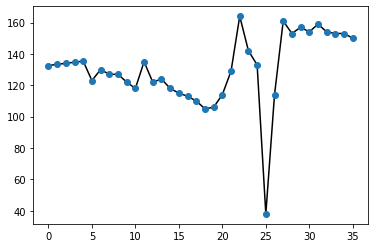

linear fit


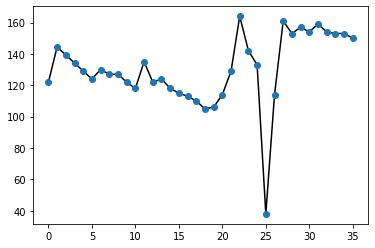

linear fit


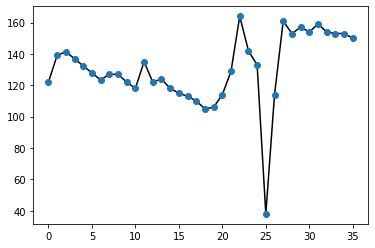

linear fit


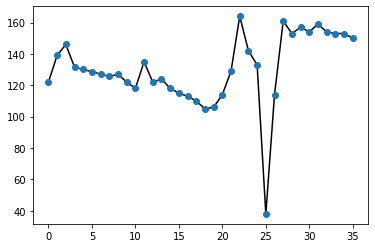

linear fit


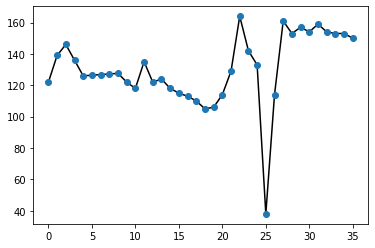

linear fit


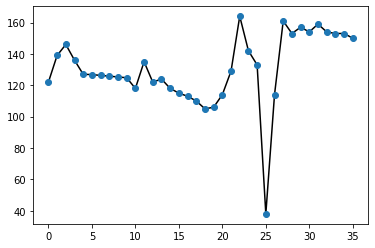

linear fit


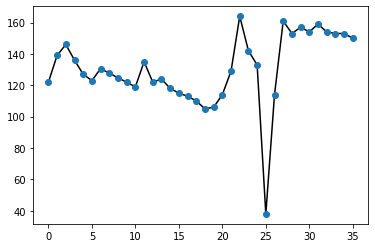

linear fit


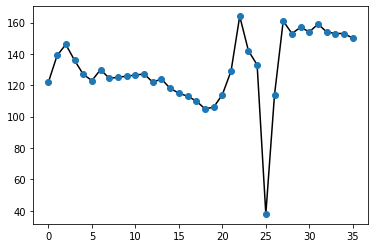

linear fit


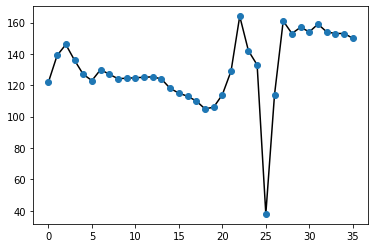

linear fit


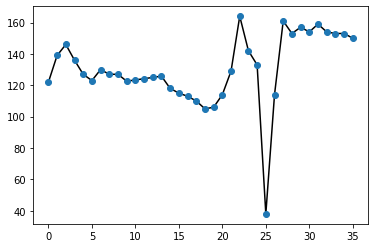

linear fit


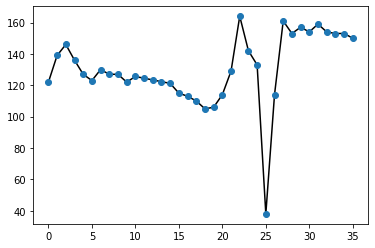

linear fit


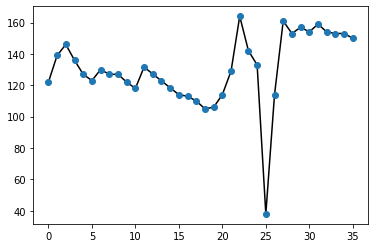

linear fit


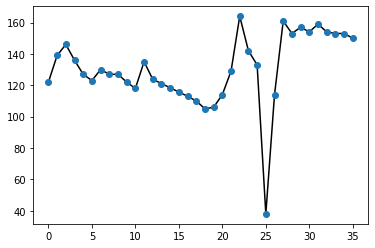

linear fit


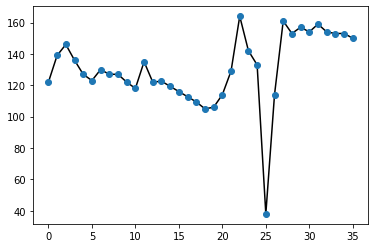

linear fit


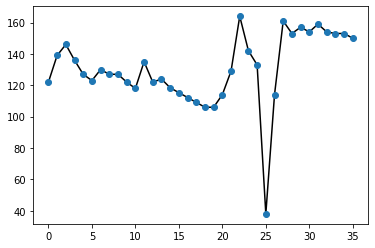

linear fit


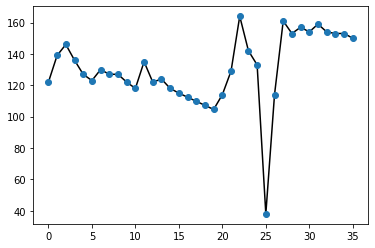

linear fit


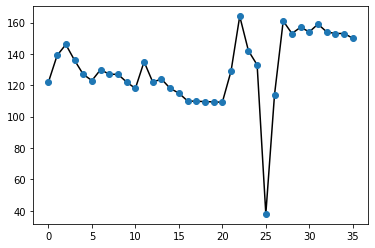

linear fit


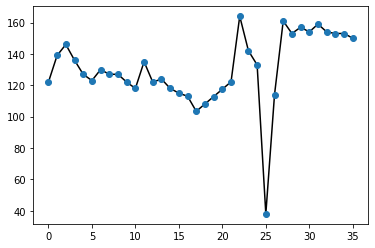

linear fit


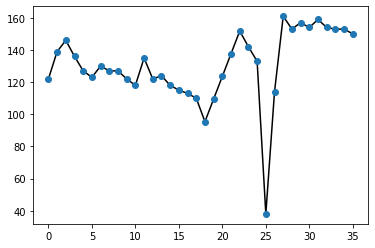

linear fit


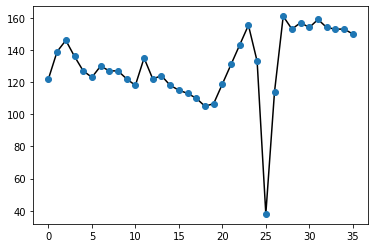

linear fit


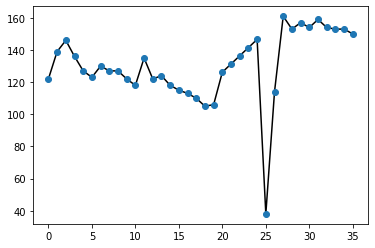

linear fit


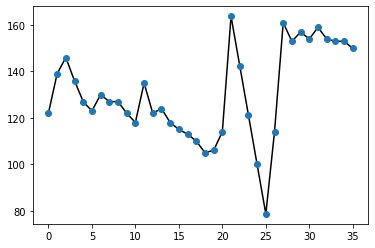

linear fit


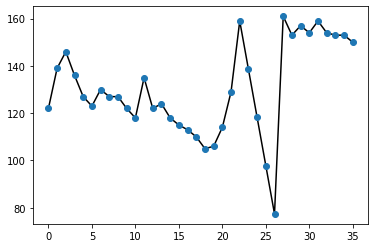

linear fit


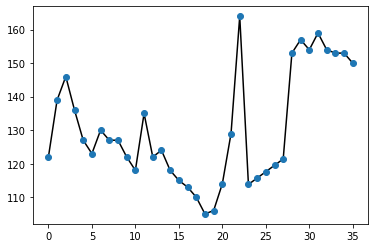

linear fit


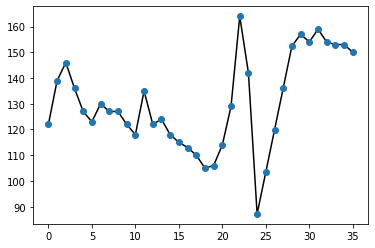

linear fit


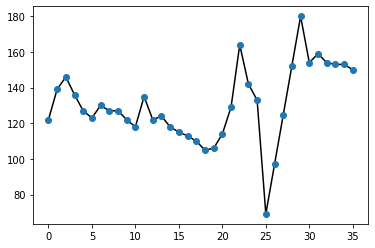

linear fit


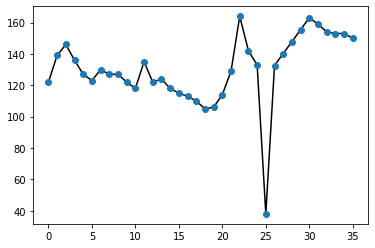

linear fit


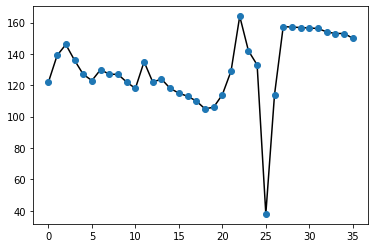

linear fit


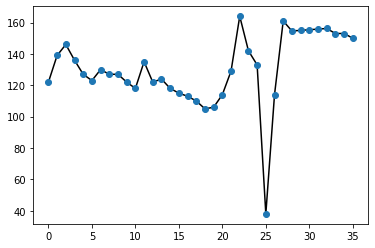

linear fit


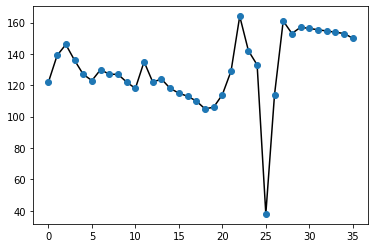

linear fit


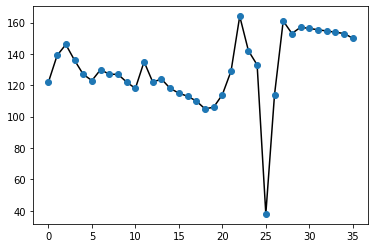

linear fit


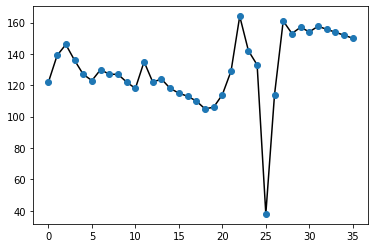

linear fit


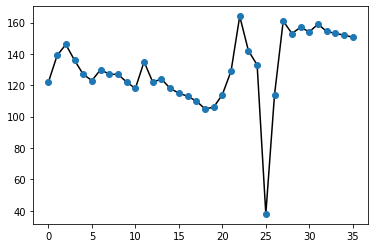

linear fit


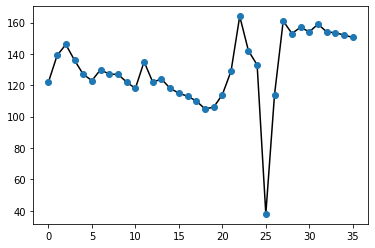

linear fit


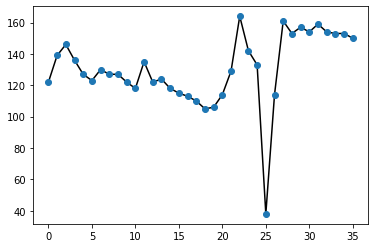

linear fit


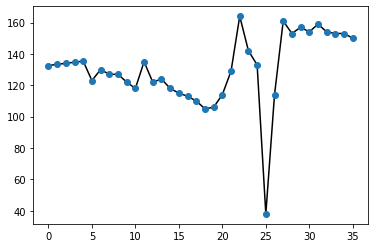

linear fit


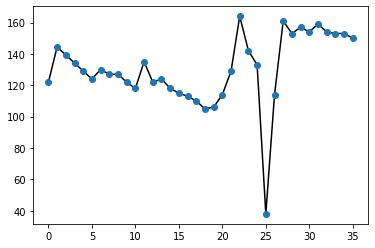

linear fit


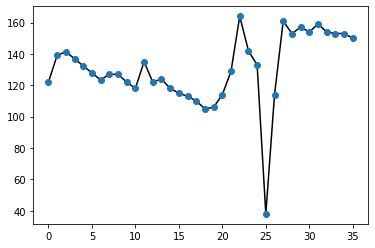

linear fit


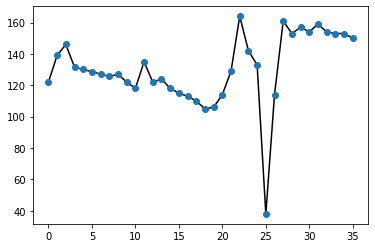

linear fit


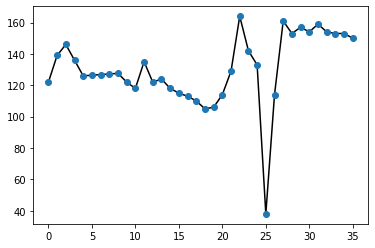

linear fit


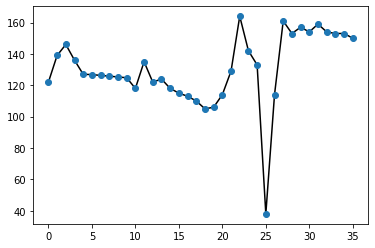

linear fit


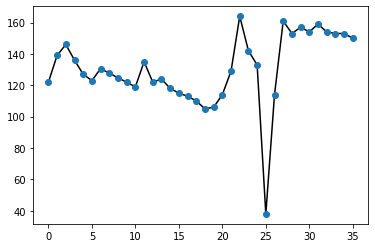

linear fit


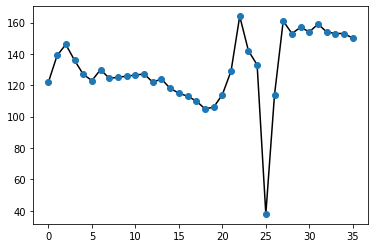

linear fit


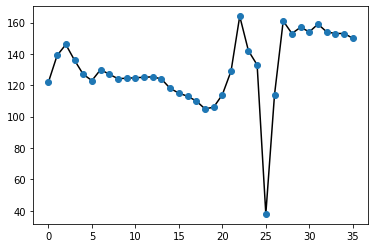

linear fit


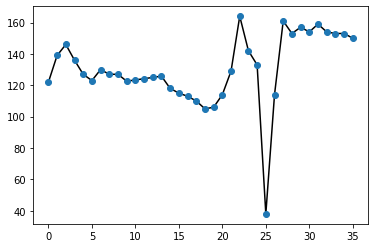

linear fit


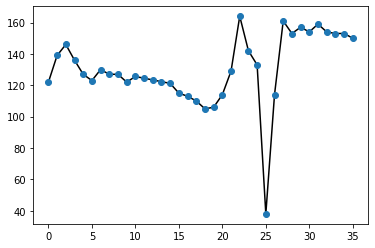

linear fit


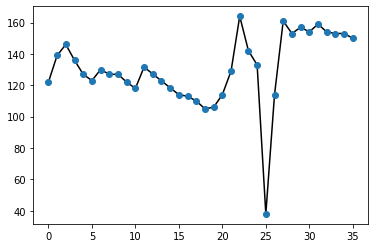

linear fit


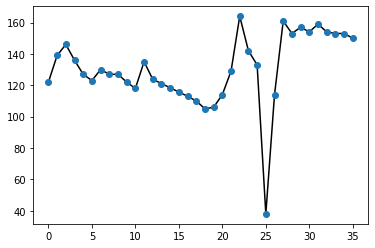

linear fit


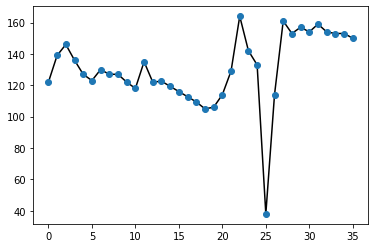

linear fit


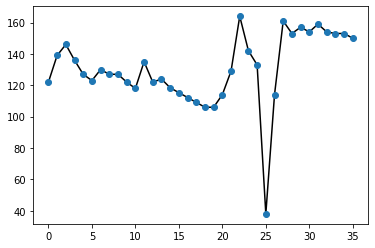

linear fit


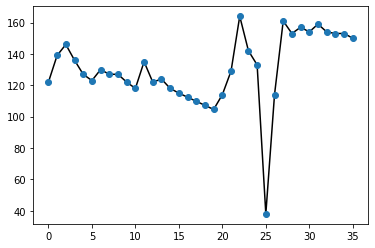

linear fit


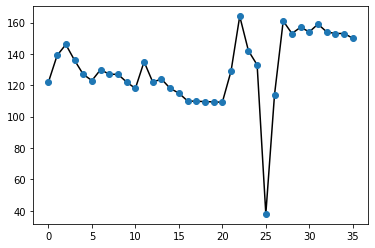

linear fit


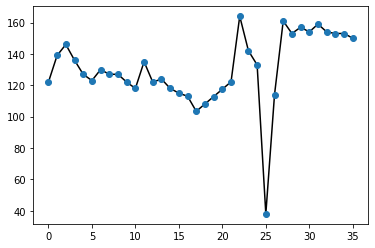

linear fit


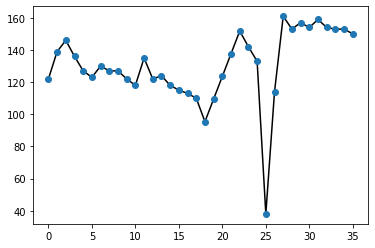

linear fit


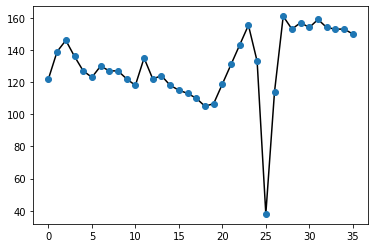

linear fit


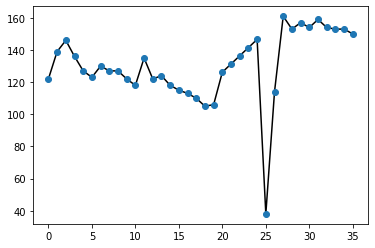

linear fit


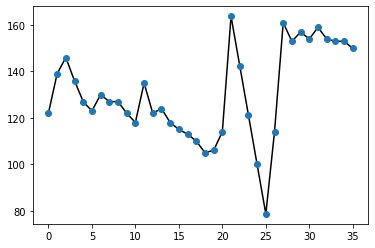

linear fit


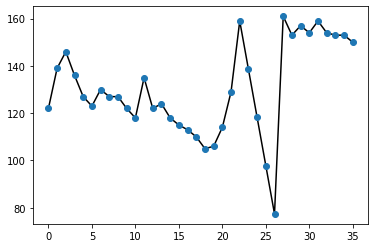

linear fit


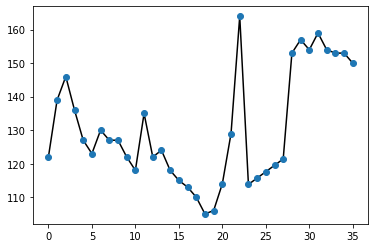

linear fit


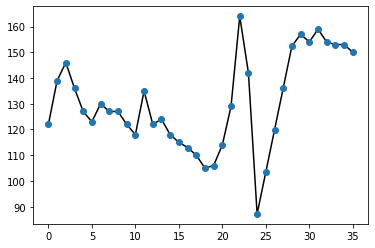

linear fit


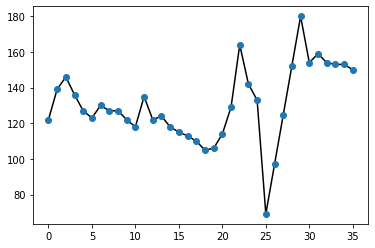

linear fit


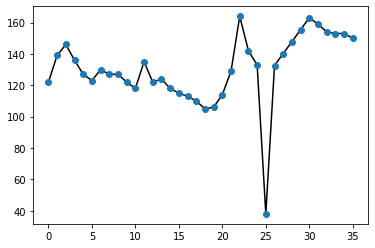

linear fit


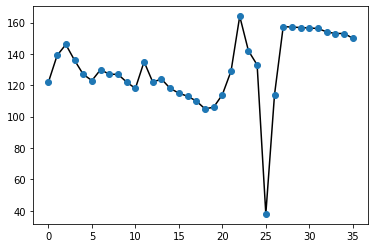

linear fit


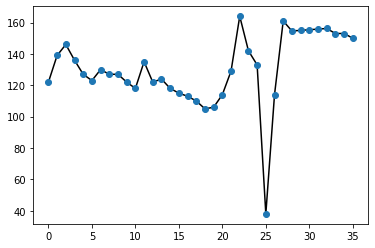

linear fit


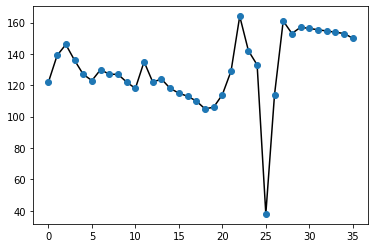

linear fit


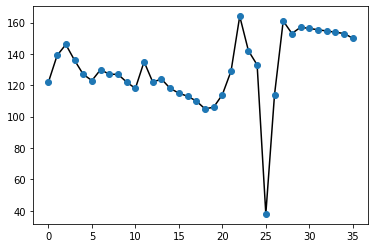

linear fit


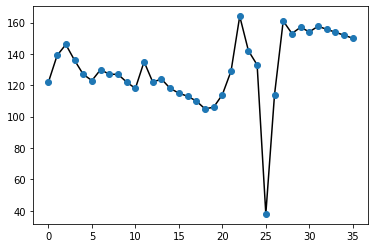

linear fit


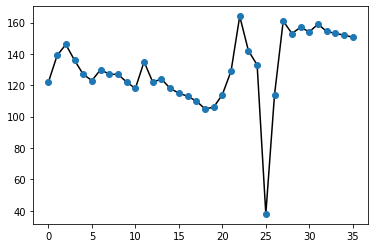

linear fit


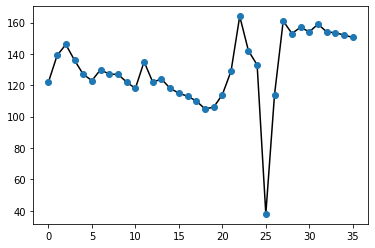

linear fit


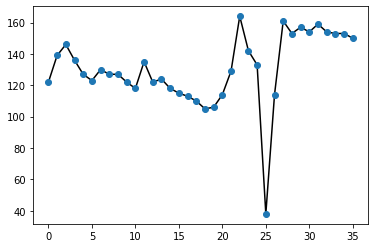

linear fit


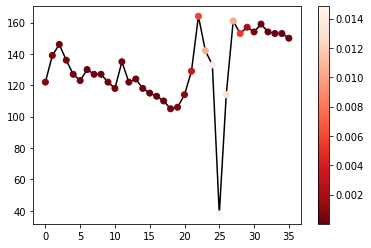

In [37]:
pulse_id = get_record_id_from_name("Pulse", "SURGERY_VITAL_SIGNS")
pulse_feature_name_mean = "MEAN(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = %s)" % (pulse_id)
pulse_feature_name_std = "STD(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = %s)" % (pulse_id)
pulse_feature_name_trend = "TREND(SURGERY_VITAL_SIGNS.VALUE, MONITOR_TIME WHERE ITEMID = %s)" % (pulse_id)

pulse_contributions, pulse_signal = occlusion_explain(pulse_id, "SURGERY_VITAL_SIGNS", ft.primitives.Std(), 
                                                      pulse_feature_name_trend, 885705, return_signal=True, record_format=False)

record_contributions = occlusion_explain(pulse_id, "SURGERY_VITAL_SIGNS", ft.primitives.Std(), 
                                         pulse_feature_name_trend, 885705)
visualize_signal(pulse_signal, c=pulse_contributions)

In [10]:
def transform(x):
    # Transform x using a list of transformers
    
    trans_x = x.copy()
    for transformer in transformers:
        trans_x = transformer.transform(trans_x)
    return trans_x

def run_occlusion_shap(signal, primitive, x, feature_name, algorithm, window_size=5, primitive_args=None):
    # Run the occlusion-on-shap algorithm on a signal 
    if primitive_args is None:
        primitive_args = []
    
    shap_values = explainer.shap_values(transform(x.to_numpy()))[0]
    feature_ind = x.columns.get_loc(feature_name)
    base_value = shap_values[feature_ind]
    
    v = np.zeros(len(signal))
    hits = np.zeros(len(signal))
    for start in range(len(signal)):
        occluded = occlude(signal, "linear", start, window_size)
        new_value = primitive(occluded, *primitive_args)
        x_copy = x.copy()
        x_copy[feature_name] = new_value
        new_shap_value = explainer.shap_values(transform(x_copy.to_numpy()))[0][feature_ind]
        v[start:start+window_size] += ((base_value - new_shap_value) / np.abs(base_value)) 
        hits[start:start+window_size] += 1
    v = v / hits
    return v

def occlusion_explain_shap(record_id, feature_table_name, primitive, feature_name, uni_oper_id, 
                           algorithm="linear", window_size=5,
                           return_signal=False, record_format=True):
    # Explain signal contributions using the occlusion-on-shap algorithm 
    
    signal, signal_table = extract_signal(uni_oper_id, feature_table_name, record_id)
    signal = signal.to_numpy()
    
    if uni_oper_id in X_train.index:
        x = X_train.loc[[uni_oper_id]]
    else:
        x = X_test.loc[[uni_oper_id]]

    if isinstance(primitive, ft.primitives.Trend):
        v = run_occlusion_shap(signal, primitive, x, feature_name, algorithm, window_size, 
                               primitive_args=[signal_table["MONITOR_TIME"].to_numpy()])
    else:
        v = run_occlusion_shap(signal, primitive, x, feature_name, algorithm, window_size, primitive_args=[])
    if not record_format:
        if return_signal:
            return v, signal
        return v
    records_to_contributions_df = pd.DataFrame({"ROW_ID": signal_table["ROW_ID"], "CONTRIBUTION": v})
    records_to_contributions = records_to_contributions_df.to_dict(orient='records')
    return records_to_contributions

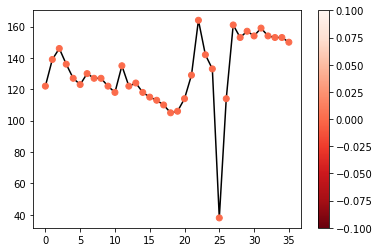

In [11]:
pulse_id = get_record_id_from_name("Pulse", "SURGERY_VITAL_SIGNS")
pulse_id = get_record_id_from_name("Pulse", "SURGERY_VITAL_SIGNS")
pulse_feature_name_mean = "MEAN(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = %s)" % (pulse_id)
pulse_feature_name_std = "STD(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = %s)" % (pulse_id)
pulse_feature_name_trend = "TREND(SURGERY_VITAL_SIGNS.VALUE, MONITOR_TIME WHERE ITEMID = %s)" % (pulse_id)

pulse_contributions, pulse_signal = occlusion_explain_shap(pulse_id, "SURGERY_VITAL_SIGNS", ft.primitives.Trend(), 
                                                           pulse_feature_name_trend, 885705, return_signal=True, record_format=False, 
                                                           window_size=5)

record_contributions = occlusion_explain_shap(pulse_id, "SURGERY_VITAL_SIGNS", ft.primitives.Trend(), 
                                                           pulse_feature_name_trend, 885705, window_size=5)
visualize_signal(pulse_signal, c=pulse_contributions)